### Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from yome import Session
from yome.models import *
from yome.util import to_df
import pandas as pd
from os.path import dirname, realpath, join
import glob
import logging

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Query for Specific Genes and bnumbers in SauerMet

## Import and format Sauermet Data

In [2]:
sauermet1 = pd.read_csv('sauermet_known.csv', sep = '\t')
sauermet2 = pd.read_csv('sauermet_unknown.csv', sep = '\t')
sauermet = pd.concat([sauermet1, sauermet2], 0)
#sauermet = sauermet.drop_duplicates()

#sauermet_old = pd.read_csv('SauerMet.csv', sep = '\t') #This is the dataset that Uwe Sauer personally sent to us pre-publication

sauermet = sauermet[sauermet.annotation.notnull()] #gets rid of all genes that act upon indistinguishable metabolites
sauermet.rename(columns= lambda x: x.replace(' ', '_'), inplace = True)
sauermet.rename(columns = lambda x: x.replace('.', '_'), inplace = True)
sauermet.rename(columns = lambda x: x.replace('-', '_'), inplace = True)
sauermet.rename(columns = {'locus_tag': 'bnum'}, inplace = True)

In [3]:
len(sauermet)

233

## Export Formatted Sauermet Data

In [4]:
#sauermet.to_csv('sauermet_edited.csv', sep = '\t', index = False) #export an edited Sauermet csv with no unnannotated metabolite rows

# Create/Export a Table of Disagreeing Annotations from SauerMet

## Import Y-ome and Non Y-ome Genes from PSQL

In [5]:
session = Session()
genes = to_df(
    session.query(Gene.locus_id, KnowledgebaseGene.primary_name, Synonym.synonym, Knowledgebase.name, KnowledgebaseGene.annotation_quality)
    .join(KnowledgebaseGene)
    .join(Synonym, KnowledgebaseGene.id == Synonym.ref_id)
    .join(Knowledgebase)
    .filter(Knowledgebase.name == 'Y-ome')
    , ['bnum', 'gene_name', 'syn', 'knowledgebase', 'ann_quality']
) 

session.close()

In [6]:
change = genes[genes.syn==genes.gene_name]
genes.loc[change.index, 'syn'] = 'None'
genes = genes.drop_duplicates()
genes.index = range(0, len(genes))

drop1 = genes[genes.syn.isin(genes.bnum)]
drop2 = genes[genes.syn.isin(genes.gene_name)]
drop = pd.concat([drop1, drop2], 0)

genes = genes.drop(genes.index[[drop.index]])
yome = genes[genes.ann_quality == 'low']
well = genes[genes.ann_quality == 'high']

yome_uniq = yome.drop(['syn'],1)
yome_uniq = yome_uniq.drop_duplicates()
well_uniq = well.drop(['syn'],1)
well_uniq = well_uniq.drop_duplicates()
genes_uniq = genes.drop(['syn'],1)
genes_uniq = genes_uniq.drop_duplicates()

yome.index = range(0,len(yome))
well.index = range(0,len(well))
genes.index = range(0,len(genes))

In [7]:
len(yome), len(well), len(genes)

(4514, 9642, 14156)

In [8]:
len(yome_uniq), len(well_uniq), len(genes_uniq)

(1930, 2669, 4599)

## Input Queries either as a Series of bnums/gene names or from a txt 

In [9]:
query_pre = ['b0419', 'b0542', 'yaiE']
#query = pd.read_csv('*insert file here*', sep = '\t') #use to query from csv files
#query1 = query.*insert bnum column here* 
#query2 = query.*insert gene name column here*
#query = pd.concat([query1, query2], 0)
#query_pre = list(query)

q1 = genes[genes.bnum.isin(query_pre)]
q2 = genes[genes.gene_name.isin(query_pre)]
q3 = genes[genes.syn.isin(query_pre)]
qt = pd.concat([q1,q2,q3],0)
qt = qt.drop_duplicates()

query = list(qt.syn) + list(qt.bnum) + list(qt.gene_name)

In [10]:
sauermet_query1 = sauermet[sauermet.bnum.isin(query)]
sauermet_query2 = sauermet[sauermet.gene_name.isin(query)]
sauermet_query = pd.concat([sauermet_query1, sauermet_query2], 0)
sauermet_query = sauermet_query.drop_duplicates()
sauermet_query = sauermet_query.dropna(axis=1, how='all')
sauermet_query

,Z_score_lysate,Z_score_pure,annotation,annotation_1,annotation_10,annotation_11,annotation_12,annotation_13,annotation_14,annotation_15,annotation_16,annotation_17,annotation_18,annotation_19,annotation_2,annotation_20,annotation_21,annotation_22,annotation_23,annotation_24,annotation_25,annotation_3,annotation_4,annotation_5,annotation_6,annotation_7,annotation_8,annotation_9,change_direction,gene_annotation,gene_name,hit_in_which_assay?,ion_m/z,bnum
8,5.28,-0.17,Acetate [M-H [CORR]]-,Uracil [M-H [CORR]]-,Glycolaldehyde [M-H [CORR]]-,L-Homoserine [M+F [CORR]]-,3-Methoxyanthranilate [M-H [CORR]]-,3-Hydroxy-4-hydroxymethyl-2-methylpyridine-5-c...,Dihydroechinofuran [M+F [CORR]]-,L-Allothreonine [M+F [CORR]]-,Isopyridoxal [M-H [CORR]]-,L-erythro-4-Hydroxyglutamate [M+F [CORR]]-,alpha-Ribazole [M-H [CORR]]-,L-Glutamate [M+F [CORR]]-,L-Threonine [M+F [CORR]]-,D-Glutamate [M+F [CORR]]-,DL-Glutamate [M+F [CORR]]-,O-Acetyl-L-serine [M+F [CORR]]-,L-threo-3-Methylaspartate [M+F [CORR]]-,L-4-Hydroxyglutamate semialdehyde [M+F [CORR]]-,2-Oxo-4-hydroxy-5-aminovalerate [M+F [CORR]]-,L-Histidine [M-H [CORR]]-,Pyridoxal [M-H [CORR]]-,Toluene-4-sulfonate [M+1 M-H [CORR]]-,4-Pyridoxate [M-H [CORR]]-,O-Phospho-L-serine [M-H [CORR]]-,N6-Acetyl-N6-hydroxy-L-lysine [M+F [CORR]]-,Pantetheine [M-H [CORR]]-,product,"conserved protein, UPF0345 family",yaiE,LYSATE ONLY,269.0886,b0391
14,-5.33,-0.34,S-(Formylmethyl)glutathione [M-H]-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,substrate,"2-carboxybenzaldehyde reductase, function unknown",yajO,LYSATE ONLY,348.0881,b0419


## Find Mismatches and Create Table

In [11]:
mismatch1 = yome[yome.gene_name.isin(sauermet1['gene name'])]
mismatch2 = yome[yome.bnum.isin(sauermet1['locus tag'])]
mismatch3 = yome[yome.syn.isin(sauermet1['gene name'])]
mismatch4 = yome[yome.syn.isin(sauermet1['locus tag'])]

mismatch5 = well[well.gene_name.isin(sauermet2['gene name'])]
mismatch6 = well[well.bnum.isin(sauermet2['locus tag'])]
mismatch7 = well[well.syn.isin(sauermet2['gene name'])]
mismatch8 = well[well.syn.isin(sauermet2['locus tag'])]

yknown = pd.concat([mismatch1, mismatch2, mismatch3, mismatch4], 0)
yknown = yknown.drop(['syn'],1)
yknown = yknown.drop_duplicates()
wunknown = pd.concat([mismatch5, mismatch6, mismatch7, mismatch8], 0)
wunknown = wunknown.drop(['syn'],1)
wunknown = wunknown.drop_duplicates()

yknown['sauermet_quality'] = 'high'
wunknown['sauermet_quality'] = 'low'

sauermet_disagree = pd.concat([yknown, wunknown],0)
#sauermet_disagree.to_csv('sauermet_disagree.csv', sep = '\t', index = False)

In [12]:
len(yknown), len(wunknown)

(1, 27)

In [13]:
print('There are', len(sauermet_disagree), 'genes that have different annotation_qualities in SauerMet and our Y-ome database')

There are 28 genes that have different annotation_qualities in SauerMet and our Y-ome database


# Looking at Y-ome and non Y-ome Genes in SauerMet

In [14]:
yome_sm1 = sauermet[sauermet.bnum.isin(yome.bnum)]
yome_sm2 = sauermet[sauermet.gene_name.isin(yome.gene_name)]
yome_sm3 = sauermet[sauermet.bnum.isin(yome.syn)]
yome_sm4 = sauermet[sauermet.gene_name.isin(yome.syn)]
smy = pd.concat([yome_sm1, yome_sm2, yome_sm3, yome_sm4], 0)
smy = smy.drop_duplicates()

well_sm1 = sauermet[sauermet.bnum.isin(well.bnum)]
well_sm2 = sauermet[sauermet.gene_name.isin(well.gene_name)]
well_sm3 = sauermet[sauermet.bnum.isin(well.syn)]
well_sm4 = sauermet[sauermet.gene_name.isin(well.syn)]
smw = pd.concat([well_sm1, well_sm2, well_sm4], 0)
smw = smw.drop_duplicates()

In [15]:
len(sauermet), len(smy), len(smw) #all genes with hits in this survey are in our database

(233, 110, 123)

## how many unique y-genes and well-annotated genes had metabolite hits in this assay?

In [16]:
smy_unique = smy[['bnum', 'gene_name']]
smy_unique = smy_unique.drop_duplicates()
smw_unique = smw[['bnum', 'gene_name']]
smw_unique = smw_unique.drop_duplicates()

In [17]:
print('There were', len(smy_unique), 'y-ome genes and', len(smw_unique), 'well-annotated genes that affected a metabolites concentration (z-score > 5) in Sauermet')

There were 51 y-ome genes and 41 well-annotated genes that affected a metabolites concentration (z-score > 5) in Sauermet


## How many y-genes with products? substrates? how about well-annotated genes? 

In [18]:
smy_prod = smy[smy.change_direction == 'product']
smw_prod = smw[smw.change_direction == 'product']
smy_subs = smy[smy.change_direction == 'substrate']
smw_subs = smw[smw.change_direction == 'substrate']

smy_prod_uniq = smy_prod[['bnum', 'gene_name']]
smy_prod_uniq = smy_prod_uniq.drop_duplicates()
smy_subs_uniq = smy_subs[['bnum', 'gene_name']]
smy_subs_uniq = smy_subs_uniq.drop_duplicates()
smw_prod_uniq = smw_prod[['bnum', 'gene_name']]
smw_prod_uniq = smw_prod_uniq.drop_duplicates()
smw_subs_uniq = smw_subs[['bnum', 'gene_name']]
smw_subs_uniq = smw_subs_uniq.drop_duplicates()

In [19]:
ps_data = {'ann_quality': ['y-ome', 'well'], 
           'Unique Genes w/ Products': [len(smy_prod_uniq), len(smw_prod_uniq)],
           'Percentage of Unique Genes w/ Products': [100*len(smy_prod_uniq)/len(smy_unique), 100*len(smw_prod_uniq)/len(smw_unique)],
           '# of Assays w/ Products': [len(smy_prod), len(smw_prod)],
           'Unique Genes w/ Substrates': [len(smy_subs_uniq), len(smw_subs_uniq)],
           'Percentage of Unique Genes w/ Substrates': [100*len(smy_subs_uniq)/len(smy_unique), 100*len(smw_subs_uniq)/len(smw_unique)],
           '# of Assays w/ Substrates': [len(smy_subs), len(smw_subs)]}

ps_table = pd.DataFrame(data=ps_data, index = range(0,2))

In [20]:
ps_table

,# of Assays w/ Products,# of Assays w/ Substrates,Percentage of Unique Genes w/ Products,Percentage of Unique Genes w/ Substrates,Unique Genes w/ Products,Unique Genes w/ Substrates,ann_quality
0,90,20,88.235294,25.490196,45,13,y-ome
1,68,55,75.609756,53.658537,31,22,well


In [21]:
smy_prod1 = smy_prod_uniq
smy_prod1.index = range(0,len(smy_prod1))
smy_subs1 = smy_subs_uniq
smy_subs1.index = range(0,len(smy_subs1))

smy_prodsubs = smy_prod1[smy_prod1.bnum.isin(smy_subs_uniq.bnum)]
smy_subsprod = smy_subs1[smy_subs1.bnum.isin(smy_prod_uniq.bnum)]
smy_prodonly = smy_prod1.drop(smy_prod1.index[[smy_prodsubs.index]])
smy_subsonly = smy_subs1.drop(smy_subs1.index[[smy_subsprod.index]])

smw_prod1 = smw_prod_uniq
smw_prod1.index = range(0,len(smw_prod1))
smw_subs1 = smw_subs_uniq
smw_subs1.index = range(0,len(smw_subs1))

smw_prodsubs = smw_prod1[smw_prod1.bnum.isin(smw_subs_uniq.bnum)]
smw_subsprod = smw_subs1[smw_subs1.bnum.isin(smw_prod_uniq.bnum)]
smw_prodonly = smw_prod1.drop(smw_prod1.index[[smw_prodsubs.index]])
smw_subsonly = smw_subs1.drop(smw_subs1.index[[smw_subsprod.index]])

In [22]:
excps_data = {'ann_quality': ['y-ome', 'well'],
              'Genes w/ Only Products': [len(smy_prodonly), len(smw_prodonly)],
              'Genes w/ Only Substrates': [len(smy_subsonly), len(smw_subsonly)],
              'Genes w/ Both Products and Substates': [len(smy_subsprod), len(smw_subsprod)]}

excps_table = pd.DataFrame(data=excps_data, index = range(0,2))

In [23]:
excps_table

,Genes w/ Both Products and Substates,Genes w/ Only Products,Genes w/ Only Substrates,ann_quality
0,7,38,6,y-ome
1,12,19,10,well


## Is there a Z-score effect difference between y-ome genes and well genes? 

In [24]:
smy_z = smy[['Z_score_lysate', 'Z_score_pure']]
smw_z = smw[['Z_score_lysate', 'Z_score_pure']]
smy_z_stack = pd.melt(smy_z)
smw_z_stack = pd.melt(smw_z)
smy_z_stack = smy_z_stack[smy_z_stack.value.abs()>=5]
smw_z_stack = smw_z_stack[smw_z_stack.value.abs()>=5]

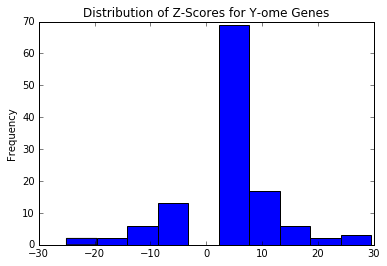

In [25]:
smy_z_stack.value.plot.hist(title='Distribution of Z-Scores for Y-ome Genes') #negative = substrate, positive = product

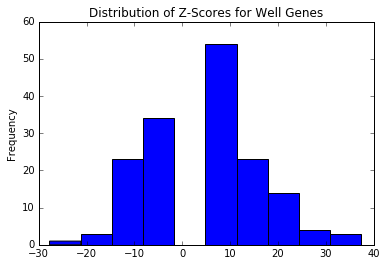

In [26]:
smw_z_stack.value.plot.hist(title='Distribution of Z-Scores for Well Genes')